In [1]:
import numpy as np
preds = np.load('out.npz')
imginfos = np.load('data/dataset_extras/3dpw_test.npz')
print(list(preds.keys()))
print(list(imginfos.keys()))

['pred_joints', 'pose', 'betas', 'camera']
['imgname', 'center', 'scale', 'pose', 'shape', 'gender']


In [2]:
print(a['pose'].shape)
print(len(b['imgname']))
print(imginfos['center'].shape)

NameError: name 'a' is not defined

/local/home/haowang/projects/ethz_master_thesis_build/smpl_demo/coco6.png


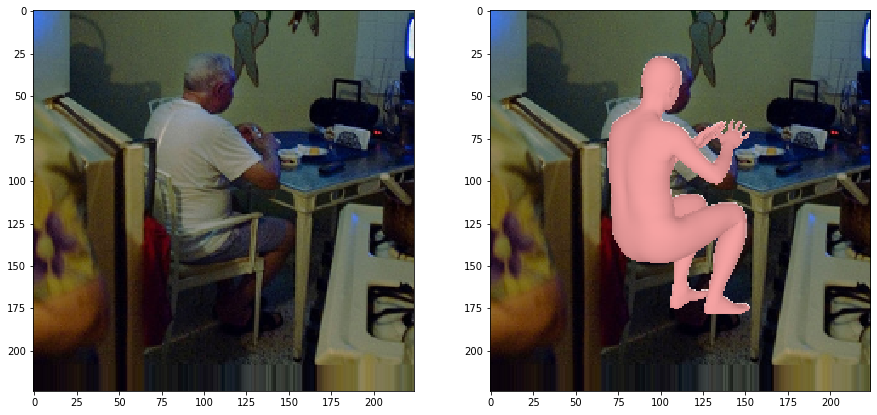

/local/home/haowang/projects/ethz_master_thesis_build/smpl_demo/coco5.png


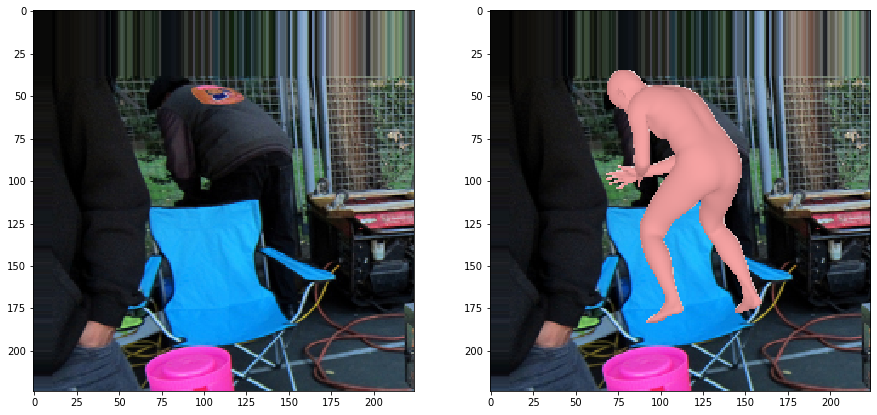

/local/home/haowang/projects/ethz_master_thesis_build/smpl_demo/coco3.png


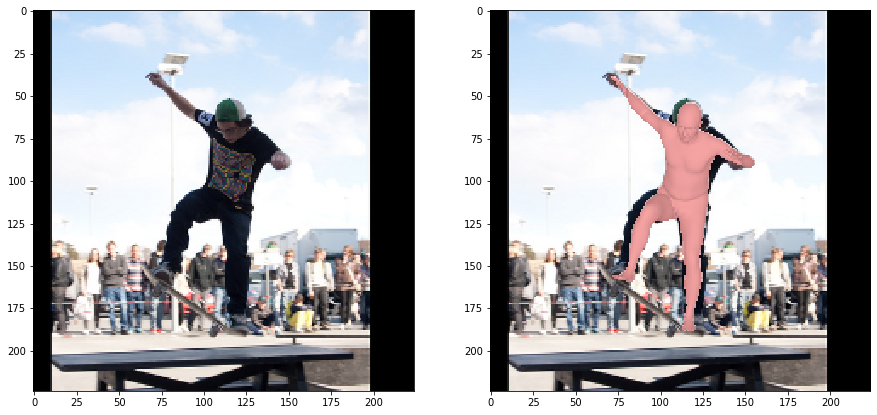

/local/home/haowang/projects/ethz_master_thesis_build/smpl_demo/im1963.jpg


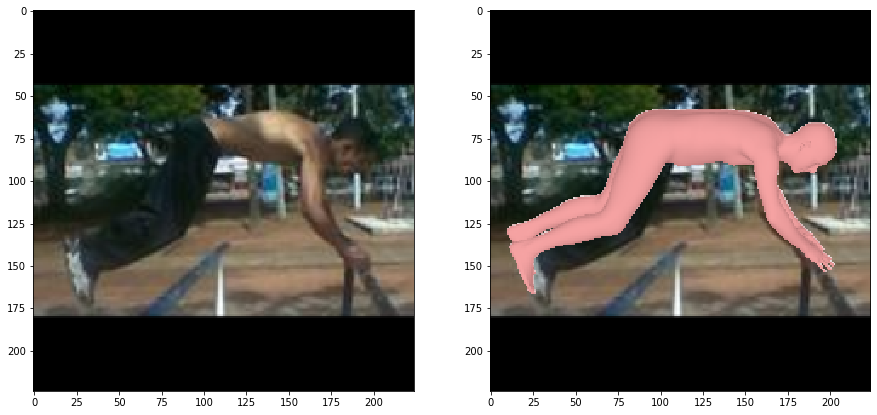

/local/home/haowang/projects/ethz_master_thesis_build/smpl_demo/im1954.jpg


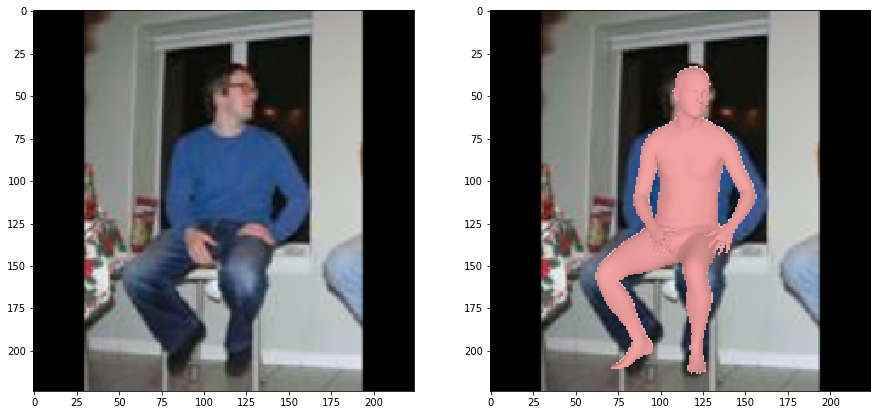

/local/home/haowang/projects/ethz_master_thesis_build/smpl_demo/random.jpg


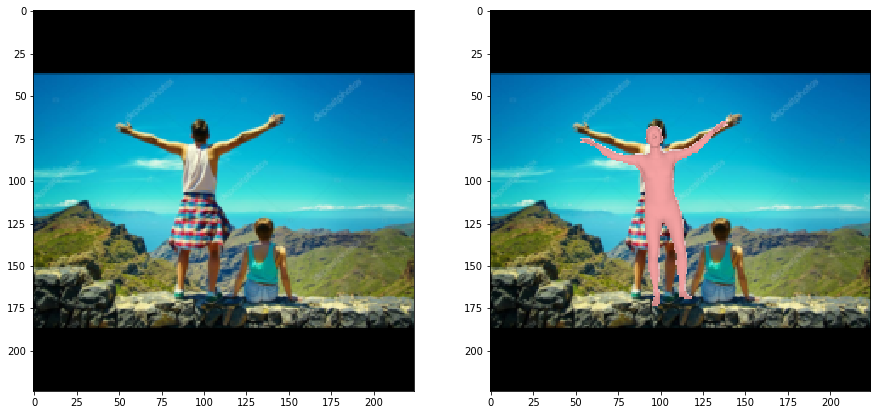

/local/home/haowang/projects/ethz_master_thesis_build/smpl_demo/coco2.png


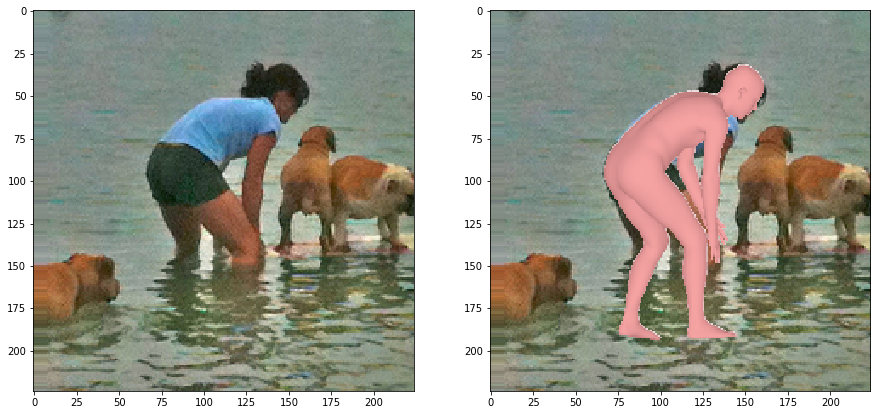

/local/home/haowang/projects/ethz_master_thesis_build/smpl_demo/coco1.png


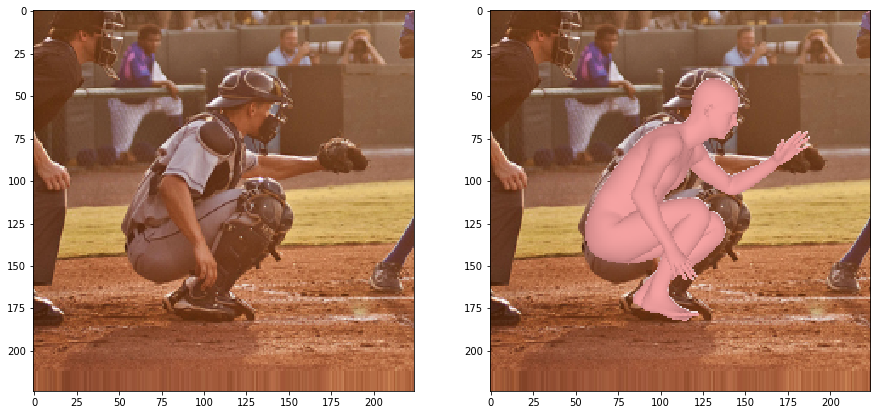

/local/home/haowang/projects/ethz_master_thesis_build/smpl_demo/coco4.png


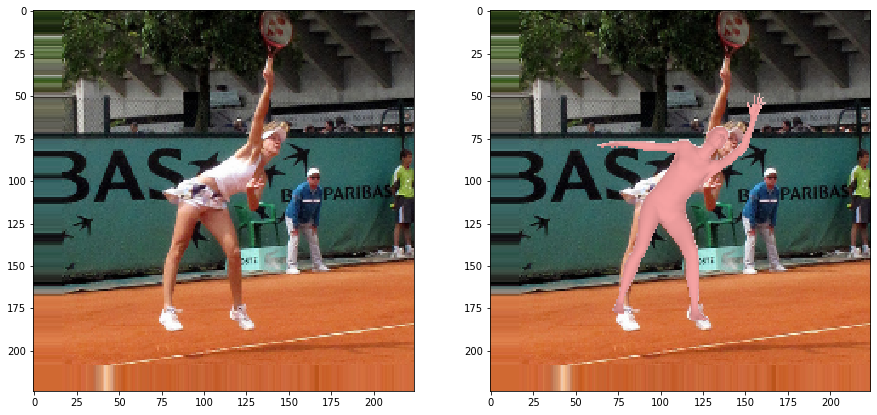

In [11]:
import torch
from torchvision.transforms import Normalize
import numpy as np
import cv2
import argparse
import json

from models import hmr, SMPL
from utils.imutils import crop
from utils.renderer import Renderer
import config
import constants

import os
import matplotlib.pyplot as plt
import random

def process_image(img_file, bbox_file=None, openpose_file=None, center=None, scale=None, input_res=224):
    """Read image, do preprocessing and possibly crop it according to the bounding box.
    If there are bounding box annotations, use them to crop the image.
    If no bounding box is specified but openpose detections are available, use them to get the bounding box.
    """
    normalize_img = Normalize(mean=constants.IMG_NORM_MEAN, std=constants.IMG_NORM_STD)
    img = cv2.imread(img_file)[:,:,::-1].copy() # PyTorch does not support negative stride at the moment
    if bbox_file is None and openpose_file is None:
        # Assume that the person is centerered in the image
        height = img.shape[0]
        width = img.shape[1]
        if center is None:
            center = np.array([width // 2, height // 2])
        if scale is None:
            scale = max(height, width) / 200
    else:
        if bbox_file is not None:
            center, scale = bbox_from_json(bbox_file)
        elif openpose_file is not None:
            center, scale = bbox_from_openpose(openpose_file)
    img = crop(img, center, scale, (input_res, input_res))
    img = img.astype(np.float32) / 255.
    img = torch.from_numpy(img).permute(2,0,1)
    norm_img = normalize_img(img.clone())[None]
    return img, norm_img

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load pretrained model
model = hmr(config.SMPL_MEAN_PARAMS).to(device)
checkpoint = torch.load('data/model_checkpoint.pt')
model.load_state_dict(checkpoint['model'], strict=False)

# Load SMPL model
smpl = SMPL(config.SMPL_MODEL_DIR,
                batch_size=1,
                create_transl=False).to(device)
model.eval()

# Setup renderer for visualization
renderer = Renderer(focal_length=constants.FOCAL_LENGTH, img_res=constants.IMG_RES, faces=smpl.faces)
l = list(range(len(imginfos['imgname'])))
random.shuffle(l)

test_list = ['flat_guitar_01/image_00170.jpg', 
             'outdoors_fencing_01/image_00326.jpg',
            '/image_00170.jpg',
            '/image_00170.jpg',
            '/image_00170.jpg',
            '/image_00170.jpg',]
img_lists = os.listdir('/local/home/haowang/projects/ethz_master_thesis_build/smpl_demo/')
for cnt, ind in enumerate(img_lists):
#     imgname = os.path.join(config.PW3D_ROOT, imginfos['imgname'][ind])
    if not ind.endswith('.jpg') and not ind.endswith('.png'):
        continue
    imgname = '/local/home/haowang/projects/ethz_master_thesis_build/smpl_demo/'+ind
    print(imgname)
    center = None#imginfos['center'][ind]
    scale = None#imginfos['scale'][ind]
    # Preprocess input image and generate predictions
    img, norm_img = process_image(imgname, center=center, scale=scale, input_res=constants.IMG_RES)
    with torch.no_grad():
        pred_rotmat, pred_betas, pred_camera = model(norm_img.to(device))
        pred_output = smpl(betas=pred_betas, body_pose=pred_rotmat[:,1:], global_orient=pred_rotmat[:,0].unsqueeze(1), pose2rot=False)
        pred_vertices = pred_output.vertices
        
    # Calculate camera parameters for rendering
    camera_translation = torch.stack([pred_camera[:,1], pred_camera[:,2], 2*constants.FOCAL_LENGTH/(constants.IMG_RES * pred_camera[:,0] +1e-9)],dim=-1)
    camera_translation = camera_translation[0].cpu().numpy()
    pred_vertices = pred_vertices[0].cpu().numpy()
    img = img.permute(1,2,0).cpu().numpy()

    
    # Render parametric shape
    img_shape = renderer(pred_vertices, camera_translation, img)
    
    fig, ax = plt.subplots(1, 2, figsize=(15,10))
    ax[0].imshow(img)
    ax[1].imshow(img_shape)

    plt.show()
    
#     break
    
    if cnt > 50:
        break
